In [1]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterSampler 
from sklearn.model_selection import cross_val_score, learning_curve
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from collections import Counter

In [2]:
# Go two levels up from DeepLearning to reach Bookify
BASE_DIR = os.getcwd()

# Correct path to Database/Cleaned_Datasets
DATA_DIR = "D:/Bookify.com/New folder/Database/database/cleaned_datasets"


#Define Model directory
MODEL_DIR ="D:/Bookify.com/New folder/Database/Notebooks"

In [3]:
SENTIMENT_DATA_PATH = os.path.join(DATA_DIR, "processed_reviews.csv")

# Load the cleaned review dataset
df = pd.read_csv(SENTIMENT_DATA_PATH)

In [4]:
df

,review_id,platform,asin,book_name,author,reviewer_name,review_title,review_text,rating,review_date,...,verified,helpful,combined_review,cleaned,no_stopwords,lemmatized,tokens,joined,w2v_vector,sentiment
0,48235e132322f1f1d38273eb33bde48f,Amazon,B0033UV8HI,Not Available,Not Available,Ridley,Entertaining But Average,"Jace Rankin may be short, but he's nothing to ...",3,2010-09-02,...,False,"[8, 10]",Entertaining But Average Jace Rankin may be sh...,entertaining but average jace rankin may be sh...,entertaining average jace rankin may short hes...,entertaining average jace rankin may short he ...,"['entertaining', 'average', 'jace', 'rankin', ...",entertaining average jace rankin may short he ...,[-0.36792505 -0.9909726 0.27137458 0.034692...,neutral
1,ef97bbe96ff2ffe7dfb0852e39a0e1ea,Amazon,B002HJV4DE,Not Available,Not Available,Holly Butler,Terrific menage scenes!,Great short read. I didn't want to put it dow...,5,2013-10-08,...,False,"[1, 1]",Terrific menage scenes! Great short read. I d...,terrific menage scenes great short read i didn...,terrific menage scenes great short read didnt ...,terrific menage scene great short read didnt w...,"['terrific', 'menage', 'scene', 'great', 'shor...",terrific menage scene great short read didnt w...,[-0.5433881 -1.7709152 0.67714506 -0.005419...,positive
2,ffa408e5333fda43220110b396f469d9,Amazon,B002ZG96I4,Not Available,Not Available,Merissa,Snapdragon Alley,I'll start by saying this is the first of four...,3,2014-04-11,...,False,"[0, 0]",Snapdragon Alley I'll start by saying this is ...,snapdragon alley ill start by saying this is t...,snapdragon alley ill start saying first four b...,snapdragon alley ill start saying first four b...,"['snapdragon', 'alley', 'ill', 'start', 'sayin...",snapdragon alley ill start saying first four b...,[-0.26081926 -1.2878057 0.27687296 0.119117...,neutral
3,d5b5ad9a44016bc335af15c715efa85d,Amazon,B002QHWOEU,Not Available,Not Available,Cleargrace,very light murder cozy,Aggie is Angela Lansbury who carries pocketboo...,3,2014-07-05,...,False,"[1, 3]",very light murder cozy Aggie is Angela Lansbur...,very light murder cozy aggie is angela lansbur...,light murder cozy aggie angela lansbury carrie...,light murder cozy aggie angela lansbury carry ...,"['light', 'murder', 'cozy', 'aggie', 'angela',...",light murder cozy aggie angela lansbury carry ...,[-0.474576 -1.2394472 0.23362859 -0.098878...,neutral
4,6f54882f555c3a31bf0bc5a2d007e1e8,Amazon,B001A06VJ8,Not Available,Not Available,Rjostler,Book,I did not expect this type of book to be in li...,4,2012-12-31,...,False,"[0, 1]",Book I did not expect this type of book to be ...,book i did not expect this type of book to be ...,book expect type book library pleased find pri...,book expect type book library pleased find pri...,"['book', 'expect', 'type', 'book', 'library', ...",book expect type book library pleased find pri...,[ 0.35064948 -1.2930781 0.01877313 0.345010...,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79462,0bbafa54ee3f1f8485989d717f8e0285,CustomerReviews,1492646318,How to Catch an Elf,Adam Wallace,Carol Mccoy,A cute Christmas book for STEM,Definitely a cute read aloud book to get kids ...,5,2023-09-04,...,1.0,0,A cute Christmas book for STEM Definitely a cu...,a cute christmas book for stem definitely a cu...,cute christmas book stem definitely cute read ...,cute christmas book stem definitely cute read ...,"['cute', 'christmas', 'book', 'stem', 'definit...",cute christmas book stem definitely cute read ...,[-0.16936101 -0.6945811 0.3211885 -0.084966...,positive
79463,7898c8d5febb0343f769a569dbd086a8,CustomerReviews,1501161938,The Seven Husbands of Evelyn Hugo: A Novel,Morgan Housel,Chelscey,Hollywood hasn't changed much,Starting at the young age of fourteen and endi...,5,2022-04-25,...,1.0,0,Hollywood hasn't changed much Starting at the ...,hollywood hasnt changed much starting at the y...,hollywood hasnt changed much starting young ag...,hollyw

In [5]:
# Assume text and label columns
texts = df['joined']
labels = df['sentiment']

le = LabelEncoder()
y = le.fit_transform(labels)
y_cat = to_categorical(y)

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

max_len = 200
X = pad_sequences(sequences, maxlen=max_len)
max_words = len(tokenizer.word_index) + 1


In [6]:
# Train-Test split
X_train_pad, X_val_pad, y_train_cat, y_val_cat = train_test_split(X, y_cat, test_size=0.2, random_state=42)
y_train_labels = np.argmax(y_train_cat, axis=1)

# Compute class weights for LSTM
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}


In [7]:
# --- 3. LSTM Model with Tuner ---
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=hp.Choice("embed_dim", [64, 128]), input_length=max_len))
    model.add(LSTM(units=hp.Choice('units', [64, 128, 256]), return_sequences=False))
    model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(Dense(3, activation='softmax'))  # 3 classes
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='lstm_tuning_dir',
    project_name='sentiment_lstm_tuning'
)

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


Reloading Tuner from lstm_tuning_dir\sentiment_lstm_tuning\tuner0.json


In [11]:
# Search for best hyperparameters
tuner.search(X_train_pad, y_train_cat, epochs=10, validation_data=(X_val_pad, y_val_cat), callbacks=[early_stop], class_weight=class_weights_dict)

# Best model
best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)
history = model.fit(X_train_pad, y_train_cat, epochs=10, validation_data=(X_val_pad, y_val_cat), callbacks=[early_stop], class_weight=class_weights_dict)


Epoch 1/10
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 2015s 1s/step - accuracy: 0.4689 - loss: 1.0860 - val_accuracy: 0.6652 - val_loss: 0.9323
Epoch 2/10
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 907s 454ms/step - accuracy: 0.6406 - loss: 0.9677 - val_accuracy: 0.5284 - val_loss: 0.9596
Epoch 3/10
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 1020s 513ms/step - accuracy: 0.6174 - loss: 0.8850 - val_accuracy: 0.4755 - val_loss: 1.0022


Fitting 2 folds for each of 3 candidates, totalling 6 fits

Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.14      0.24      2928
     neutral       0.45      0.01      0.02      1815
    positive       0.72      0.99      0.84     11151

    accuracy                           0.72     15894
   macro avg       0.64      0.38      0.37     15894
weighted avg       0.70      0.72      0.63     15894



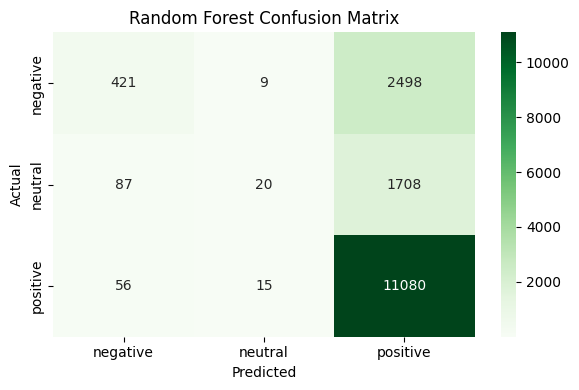

In [17]:
# --- 4. Random Forest Tuning ---

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000)  # Reduced to speed up
X_tfidf = tfidf.fit_transform(texts).toarray()
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Smaller param grid for faster tuning
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, None],
}

rf_model = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=3,             # Only 3 combinations
    scoring='accuracy',
    cv=2,                 # 2-fold CV
    n_jobs=-1,
    verbose=1
)

# Fit model
rf_search.fit(X_train_rf, y_train_rf)
best_rf = rf_search.best_estimator_

# Predictions and evaluation
y_pred_rf = best_rf.predict(X_val_rf)

print("\nRandom Forest Classification Report:")
print(classification_report(y_val_rf, y_pred_rf, target_names=le.classes_))


In [18]:
# --- 5. Evaluate LSTM ---
y_pred_lstm = model.predict(X_val_pad)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
y_val_true = np.argmax(y_val_cat, axis=1)

print("\nLSTM Classification Report:")
print(classification_report(y_val_true, y_pred_lstm, target_names=le.classes_))

497/497 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step

LSTM Classification Report:
              precision    recall  f1-score   support

    negative       0.46      0.51      0.48      2928
     neutral       0.15      0.12      0.13      1815
    positive       0.80      0.80      0.80     11151

    accuracy                           0.67     15894
   macro avg       0.47      0.47      0.47     15894
weighted avg       0.66      0.67      0.66     15894



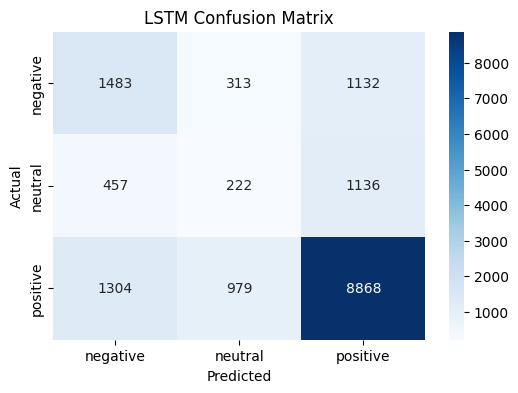

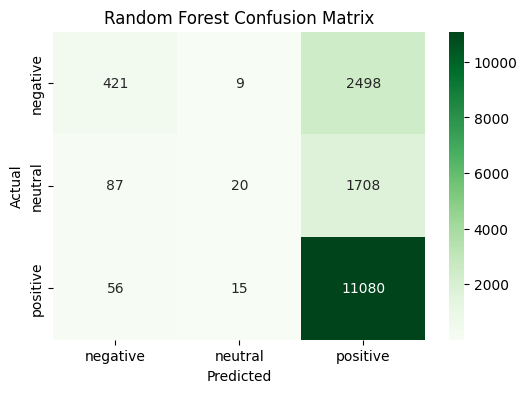

In [19]:
# LSTM Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val_true, y_pred_lstm), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
if 'y_pred_rf' not in locals():
    y_pred_rf = best_rf.predict(X_val_rf)

# Random Forest Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val_rf, y_pred_rf), annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step
497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step


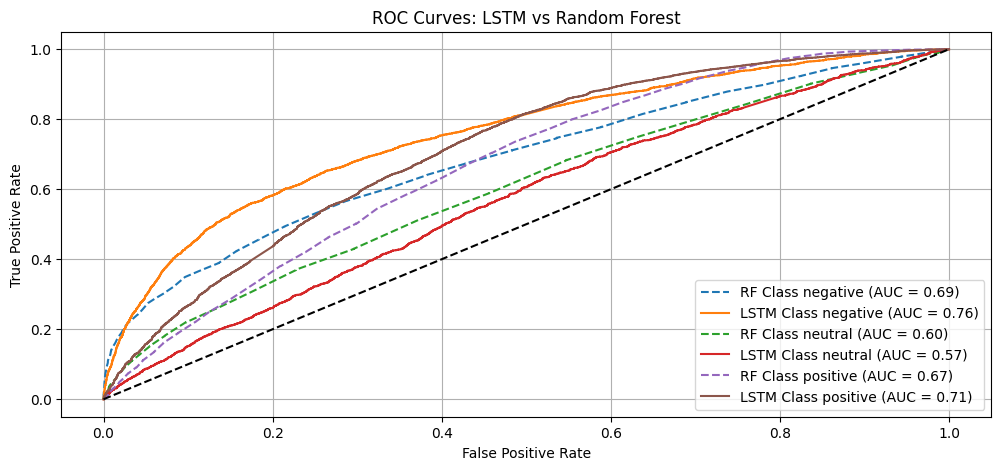

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for ROC
y_val_rf_bin = label_binarize(y_val_rf, classes=np.unique(y))
y_pred_rf_proba = best_rf.predict_proba(X_val_rf)

fpr_rf, tpr_rf, roc_auc_rf = {}, {}, {}
for i in range(3):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_val_rf_bin[:, i], y_pred_rf_proba[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# LSTM ROC
fpr_lstm, tpr_lstm, roc_auc_lstm = {}, {}, {}
for i in range(3):
    fpr_lstm[i], tpr_lstm[i], _ = roc_curve(y_val_cat[:, i], model.predict(X_val_pad)[:, i])
    roc_auc_lstm[i] = auc(fpr_lstm[i], tpr_lstm[i])

# Plot ROC curves
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.plot(fpr_rf[i], tpr_rf[i], label=f"RF Class {le.classes_[i]} (AUC = {roc_auc_rf[i]:.2f})", linestyle='--')
    plt.plot(fpr_lstm[i], tpr_lstm[i], label=f"LSTM Class {le.classes_[i]} (AUC = {roc_auc_lstm[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves: LSTM vs Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


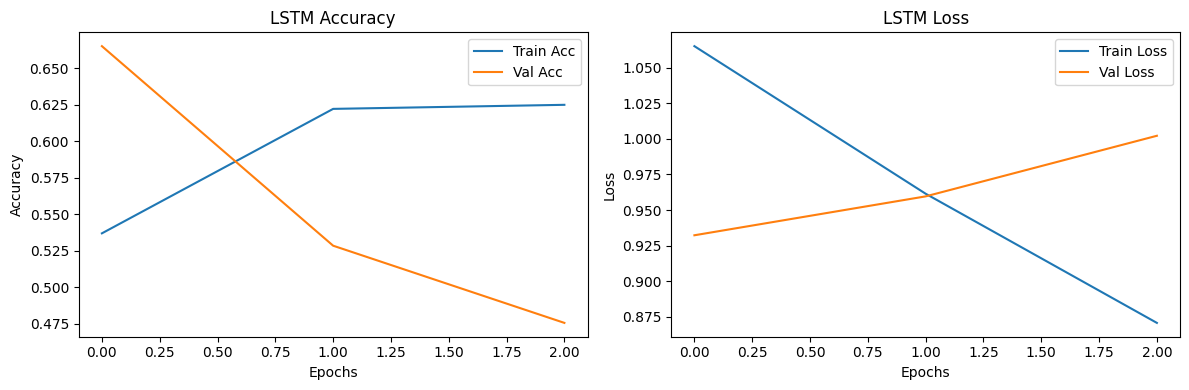

In [21]:
# Plot accuracy & loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("LSTM Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("LSTM Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


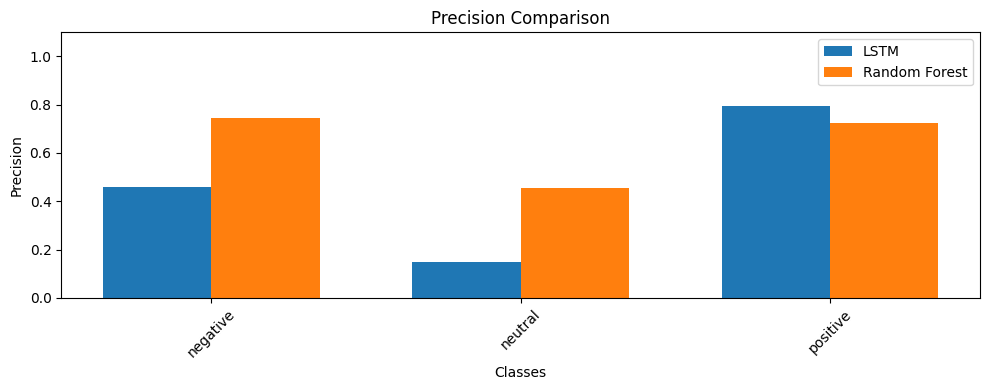

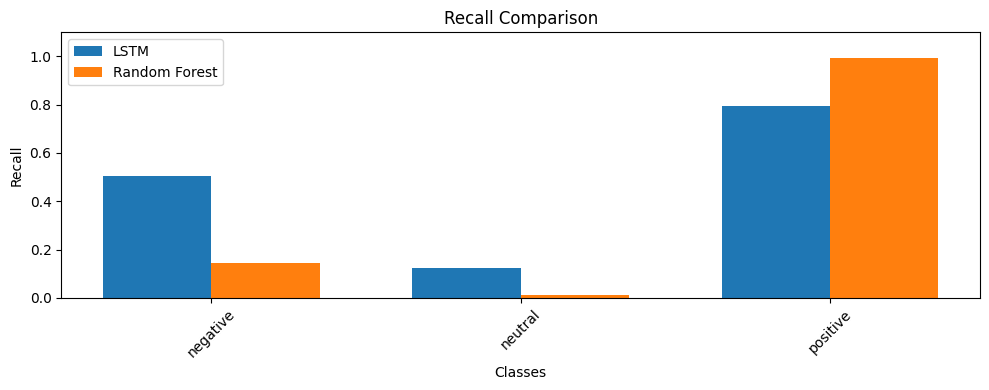

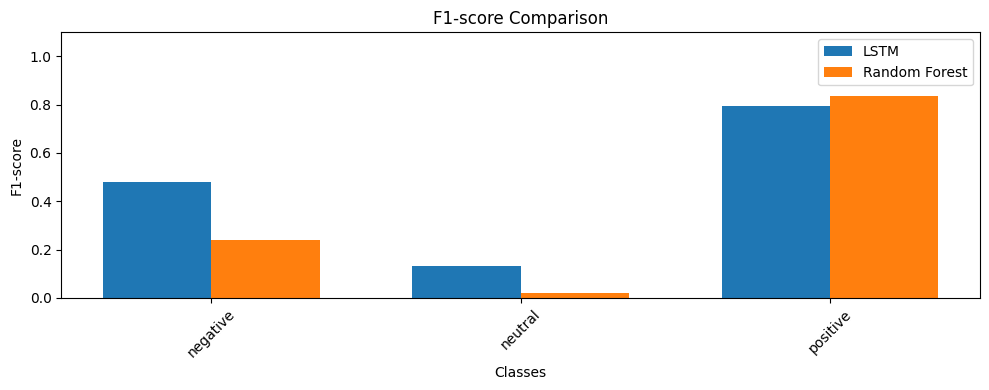

In [22]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Generate reports as dictionaries
lstm_report = classification_report(y_val_true, y_pred_lstm, target_names=le.classes_, output_dict=True)
rf_report = classification_report(y_val_rf, y_pred_rf, target_names=le.classes_, output_dict=True)

# Extract precision, recall, f1-score
metrics = ['precision', 'recall', 'f1-score']
labels = le.classes_

lstm_scores = {metric: [lstm_report[label][metric] for label in labels] for metric in metrics}
rf_scores = {metric: [rf_report[label][metric] for label in labels] for metric in metrics}

# Plot comparison
x = np.arange(len(labels))
width = 0.35

for metric in metrics:
    plt.figure(figsize=(10, 4))
    plt.bar(x - width/2, lstm_scores[metric], width, label='LSTM')
    plt.bar(x + width/2, rf_scores[metric], width, label='Random Forest')
    plt.xticks(x, labels, rotation=45)
    plt.ylim(0, 1.1)
    plt.title(f'{metric.capitalize()} Comparison')
    plt.xlabel('Classes')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.tight_layout()
    plt.show()
